Ok, let's get this starty parted.
The general design is As follows:
The model class will consist of:
    - a graph (networkx)
    - a state, that is a list/array, that maps integers(i.e. nodes) to species
    - a step function
        - interaction step
        - mutation step
    - a display function.
    
We will start with the graph and the display function, which will grant us eyes to aid in designing and testing the rest.

Ideas:
- Measure relaxation time.
- Measure acceptance probability.
- Observe speciation?
    -Find measure for diversity?

Just realised why it's not behaving as expected:
Diversity is not an asset. To find a beneficial mutation is only related how closely the species is already optimised.
-> hyperconnectivity (maybe also centralisation) is good.
    
    - Implement fitness function that's reasonable and rewards diversity?
    - Why is diversity good?
    - Derive from first principles?

Still surprising that the difference between "fight-mode" and "selfish-gene-parliament-mode" is so small. Maybe the relaxation time and acceptance probability are improved slightly, but in the simulations its not super obvious.

Experimented with a different fitness function, a hash.
This results in pseudo random values for any mutation.

Result: Fitness over time looks like abstract art, completely random, as far as i can tell. Not even an upwards trend.

Thus we learn that fitness functions are absolutely vital to the simulation and not an afterthought at all.

Talked about it with dad: back to the idea where genomes are binary finite vectors and not sets. True and False represent wether a gene is present or not. Basically the same as a replicant set, except the possible genes/replicants are predetermined and finite.

These finite vectors can be mapped onto the integers/reals with a tensor of second, third etc. order that represents the coupling/interaction of a pair of genes.
-> sum over i j ( a_i * a_j * A_ij)

This will require a complete reworking of the Species architecture. The replicant class will become obsolete.
The rest (model and ipynb) will hopefully remain largely unaffected.

Probably a good idea to save a copy of the working project as is, might come in useful.

And also lets use numpy from now on. Seems to be more performative, and since we are dealing with vectors and tensors now it's probably a good idea.


10.1.2021
All right, made the switch to vectors.
Results look different, but there is still no clear distinction between, turning "surrender"-option on and off.

Hyptothesis:
This is because most mutations cause huge differences in fitness. Therefor the chance of winning is almost 1, and therefore a beneficial mutation spreads almost as fast in "on" as in "off"-case.
So the problem still lies with the fitness function. Well actually it doesn't since in very early times (ursuppe) there would have been krass differences in fitness between replicators/vehicles, but now almost everything is close to equilibrium, so only minor gains/innovations can be made.
And my hyptothesis is that these spread much better in networks with surrender-on than surrender-off.

So, now lets mess with the fitness function, so that fitness differences are "small" and see what happens.

TODO:
   - Find a nicer solution for the data collectors.
   - Find a better way for separating control-group and non-control-group 
   - Find better name than "surrender"
   - Consider implementing a version where surrender is replaced by a 50/50 micing of the genes. (sexual reproduction). Drawback: Tenuous connection to memes.

In [1]:
import networkx as nx
import random
from species import Species
from model import Model
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
models = []
control_models = []
rep_len = 10
coupling_tensor = np.random.default_rng().uniform(-1, 1, (rep_len,rep_len))

for i in range(0,5):
    models.extend([Model(nx.cycle_graph(50), coupling_tensor, 0.01, 0, True)])
for i in range(0,5):
    control_models.extend([Model(nx.complete_graph(50), coupling_tensor, 0.01, 0, False)])

In [ ]:
class Experiment:
    
    def __init__(self, control_group, experimental_group):
        self.control_group = control_group 
        self.experimental_group = experimental_group
        self.data_collectors 

In [3]:
coupling_tensor

array([[-0.05524647, -0.80583301,  0.55647262, -0.06647159, -0.08897302,
         0.81988748,  0.53381627,  0.06458409,  0.4162997 , -0.30339813],
       [-0.42861966,  0.90121617, -0.10957063, -0.23401675,  0.77055803,
         0.96029683, -0.25657759, -0.16202888,  0.19839753,  0.95468839],
       [ 0.27091748, -0.91862793,  0.19863312, -0.53558464,  0.21509725,
         0.01408165,  0.04109214, -0.93372709, -0.90967764, -0.27412684],
       [-0.11139653, -0.29913261,  0.6669597 , -0.96090511, -0.8137659 ,
         0.91345605,  0.87671117,  0.79324458, -0.73637752,  0.84697295],
       [-0.35936881, -0.82472358,  0.59121676,  0.66833793, -0.23003371,
        -0.78181013, -0.15104882,  0.43624712, -0.15993788, -0.40183276],
       [ 0.19207718, -0.85186703, -0.65390138,  0.91642545, -0.47504396,
         0.86663696,  0.85117619,  0.40842742,  0.36432817, -0.15680238],
       [-0.62176715,  0.00697079,  0.38072373,  0.34433219, -0.76685516,
        -0.30078076,  0.08700386, -0.17375689

In [4]:
max_fitness_collectors = []
max_replicants_lens=[]
average_fitness_collectors=[]
population=[]

In [5]:
import time

start_time = time.perf_counter()
steps_per_model = 10000

for j in range(0,len(myModels)):
    print("Running model Nr.", j)
    jth_max_fitness_collector = []
    jth_max_replicants_len=[]
    jth_average_fitness_collector=[]
    jth_population=[]
    
    for i in range(0,steps_per_model):
        myModels[j].step()
        jth_max_fitness_collector.append(max([node.fitness for node in myModels[j].State]))
        jth_average_fitness_collector.append(sum([node.fitness for node in myModels[j].State])/myModels[j].N)
        jth_max_replicants_len.append(max([np.sum(node.genome) for node in myModels[j].State]))
        jth_population.append(myModels[j].N - myModels[j].State.count(myModels[j].empty_species))
        
    max_fitness_collectors.append(jth_max_fitness_collector)
    max_replicants_lens.append(jth_average_fitness_collector)
    average_fitness_collectors.append(jth_average_fitness_collector)
    population.append(jth_population)
    
total_time = time.perf_counter()-start_time
print("Time elapsed =", total_time ,". Steps per second =", total_time/(len(myModels)*steps_per_model))

Running model Nr. 0
Running model Nr. 1
Running model Nr. 2
Running model Nr. 3
Running model Nr. 4
Running model Nr. 5
Running model Nr. 6
Running model Nr. 7
Running model Nr. 8
Running model Nr. 9
Time elapsed = 46.63683733600192 . Steps per second = 0.00046636837336001916


In [6]:
import line_profiler
%load_ext line_profiler

# To actually profile a function:

%lprun -f Model.interaction_step myModels[0].step()
#             ^^^^^---- this call will be profiled
#         ^^^-----------function to profile


Timer unit: 1e-06 s

Total time: 0.000166 s
File: /home/wzrd/PycharmProjects/Replicators_Vector_Version/model.py
Function: interaction_step at line 97

Line #      Hits         Time  Per Hit   % Time  Line Contents
    97                                               def interaction_step(self):
    98                                                   """Chooses a random node and has it interact with one of its neighbors.
    99                                                   We chose to uniformly sample nodes instead of edges, since we think,
   100                                                   that it makes sense that nodes with few neighbors interact more with each of them.
   101                                                   """
   102                                                   # pick a random node
   103         1         47.0     47.0     28.3          a = random.randint(0, self.N - 1)
   104                                                   # get neighbors
   105

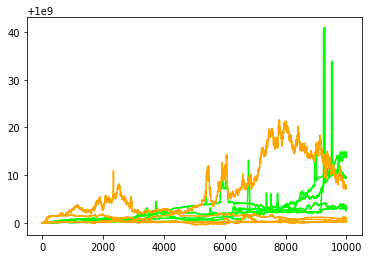

In [25]:
# plt.yscale('log')
start = 0
end = steps_per_model
for a in range(0, len(myModels)):
    if a < 5:
        plt.plot(average_fitness_collectors[a][start:end], color = 'lime')
        # plt.plot(max_fitness_collectors[a][start:end], color = 'darkgreen')
    else:
        plt.plot(average_fitness_collectors[a][start:end], color = 'orange')
        # plt.plot(max_fitness_collectors[a][start:end], color = 'red')


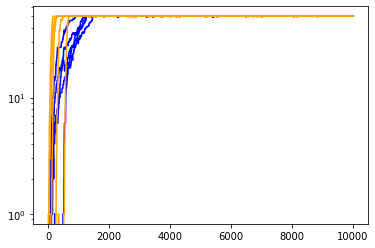

In [8]:
plt.yscale('log')
for a in range(0, len(myModels)):
    if a < 5:
        plt.plot(population[a], color = 'blue')
    else:
        plt.plot(population[a], color = 'orange')



In [9]:
# calculate probability of acceptance for a benefitial mutation.

def acceptance(max_fitness: [float]) -> float:
    # consider how often the max fitness increases, vs how often it decreases.
    # the ratio is the probability of a benefitial mutation being accepted.
    increases = 0
    decreases = 0
    for i in range(1, len(max_fitness)):
        if max_fitness[i-1] < max_fitness[i]:
            increases += 1
            # print("increase at ", i, max_fitness[i-1], "to", max_fitness[i] )
        elif max_fitness[i-1] > max_fitness[i]:
            decreases += 1
            # print("decrease at ",i, max_fitness[i-1], "to", max_fitness[i] )
    # print(decreases, increases)
    return 1 - (decreases/increases)

0.21215686274509804 0.0812781954887218


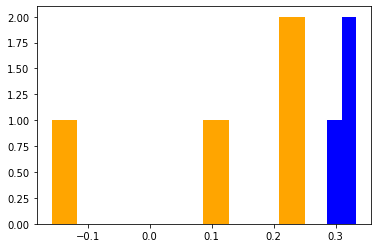

In [10]:
acceptances = [acceptance(mfc) for mfc in max_fitness_collectors]

plt.hist(acceptances[0:4], color = 'blue')

plt.hist(acceptances[5:9], color = 'orange')
acceptances
print(sum(acceptances[0:4])/5, sum (acceptances[5:9])/5)

In [15]:
[ r.fitness for r in myModels[0].State]

[1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000003.4134889,
 1000000003.4134889,
 1000000006.1359674,
 1000000006.1359674,
 1000000006.1359674,
 1000000006.1359674,
 1000000006.1359674,
 1000000006.1359674,
 1000000006.1359674,
 1000000006.1359674,
 1000000006.1359674,
 1000000006.1359674,
 1000000006.1359674,
 1000000006.1359674,
 1000000006.1359674,
 1000000000.4417089,
 1000000000.4417089,
 1000000001.0288169,
 1000000001.0288169,
 1000000000.4417089,
 1000000000.4417089,
 1000000000.4417089,
 1000000000.4417089,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000001.0288169,
 1000000003.0214623,
 1000000003.0

(array([ 6., 26.,  0.,  0.,  3.,  2.,  0.,  0.,  0., 13.]),
 array([1.00000000e+09, 1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
        1.00000000e+09, 1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
        1.00000000e+09, 1.00000001e+09, 1.00000001e+09]),
 <BarContainer object of 10 artists>)

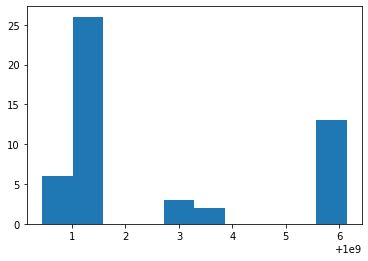

In [12]:
plt.hist([i.fitness for i in myModels[0].State])

In [13]:
zoo = sorted(set(State), key=lambda x: x.fitness,reverse=True)
print(len(State))
len(zoo)

NameError: name 'State' is not defined

In [ ]:
[(reps_in_common(i,zoo[0]), len(i.replicants)) for i in zoo[:20]]

In [ ]:
plt.plot(max_replicants_len)

In [ ]:
display()

In [ ]:
import numpy as np
cumulative_sum = np.cumsum([i.attribute for i in State[0].replicants[:]]) -1
#plt.yscale('symlog')
plt.plot(cumulative_sum)
cumulative_sum

In [ ]:
plt.hist([v for k,v in nx.degree(Graph)])

In [ ]:
def display():
    
    color_map = [i.color for i in State]
    # nx.draw_circular(Graph, node_color=color_map)
    nx.draw_spring(Graph, node_color=color_map)

In [ ]:
def reps_in_common(a,b):
    "Return the number of Replicants Species a and Species b have in common."
    return len(set(a.replicants) & set(b.replicants)) # size of the intersection set.

In [ ]:
import random
import numpy as np
v = np.ones(2, dtype = bool)
print(v)
u = v.copy()
v[0] = not v[0]
print(v, u)
random.randrange(0,len(v))
str(v)

v0 = v[0]
v0 = True
v

In [ ]:
ar =np.array([True, True, False, False, True])
ar2 =np.array([False, False, False, False, True])

(ar*ar2)

In [ ]:
r = np.zeros((2,2))
if not all([r.shape[0] == i for i in r.shape]):
    raise Exception("Coupling tensor is not square.")
leng = r.shape[0]
str(r)